<H1>Unsupervised Learning of Stock News Headlines</H1>

Stocks frequently see quick price movements after following big news. However, looking at many news headlines, many editorial and opinion type articles are mixed in with news on actual events. For example, an article titled “Five Stocks to Include in Your Retirement Portfolio” is unlikely to cause a price movement whereas articles reporting significant events about a company such as a new product offering, a change in an important leadership role, or recent earnings reportings are far more likely to trigger significant price movements. 

I hypothesize that most of these editorial articles can be filtered out using an unsupervised learning technique. Using an unsupervised learning model would avoid the need to label large amounts of the data. In this project, I will transform headline text into word frequency counts using TfidVectorizer in the package sklearn. I will then explore various unsupervised learning techniques to cluster the transformed stock news headlines in an attempt to separate editorial and opinion articles from event-driven articles. For more information, please see the full report accompanying this code.

In [40]:
# importing libraries that are used. I like to put all my imports in one place, at the beginning of the document
import pandas as pd, os, numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

import matplotlib.pyplot as plt

import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk

<H2>Data Exploration and Preparation</H2>

In [41]:
os.chdir(r'G:\My Drive\Personal Stuff\Coursera Coursework\Mach learning\Course4_Unsupervised_Learning')
data = pd.read_csv('Stock_News_Headlines_July-Aug_2023.csv')
data.head()

,Unnamed: 0,date_x,open,high,low,close,adjusted_close,volume,gains_losses,ema9,...,dji_dist_to_ema20,dji_dist_to_ema200,dji_dist_to_sma20,dji_dist_to_sma50,dji_dist_to_sma200,dji_dist_to_vwap9,dji_dist_to_vwap20,dji_dist_to_vwap200,dji_MACD_signal_m_line,New_Model_Predictions
0,0,2023-08-21,15.06,15.20,14.950,15.16,15.16,23546339,0.12,15.458932,...,-0.083043,-0.083877,0.021647,0.004915,-0.022316,0.014369,0.020591,-0.024387,-2.386324,3
1,1,2023-08-21,15.06,15.20,14.950,15.16,15.16,23546339,0.12,15.458932,...,-0.083043,-0.083877,0.021647,0.004915,-0.022316,0.014369,0.020591,-0.024387,-2.386324,3
2,2,2023-08-21,175.07,176.13,173.735,175.84,175.84,46200264,1.35,177.592493,...,-0.083043,-0.083877,0.021647,0.004915,-0.022316,0.014369,0.020591,-0.024387,-2.386324,2
3,3,2023-08-21,175.07,176.13,173.735,175.84,175.84,46200264,1.35,177.592493,...,-0.083043,-0.083877,0.021647,0.004915,-0.022316,0.014369,0.020591,-0.024387,-2.386324,2
4,4,2023-08-21,175.07,176.13,173.735,175.84,175.84,46200264,1.35,177.592493,...,-0.083043,-0.083877,0.021647,0.004915,-0.022316,0.014369,0.020591,-0.024387,-2.386324,2


In [42]:
# Convert columns to a list and print the list, otherwise the notebook won't list all the columns
columns_list = data.columns.tolist()
print(columns_list)


['Unnamed: 0', 'date_x', 'open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'gains_losses', 'ema9', 'ema20', 'ema200', 'sma20', 'sma50', 'sma200', 'RSI', 'vwap9', 'vwap20', 'vwap200', 'MACD_line', 'MACD_signal', 'stock_data_ticker', 'Merge3_index', 'date_y', 'title', 'content', 'link', 'ticker', 'polarity', 'neg', 'neu', 'pos', 'news_adjusted_date', 'buy_date', 'stock_data_date', 'index_x', 'spy_date', 'spy_open', 'spy_high', 'spy_low', 'spy_close', 'spy_adjusted_close', 'spy_volume', 'spy_gains_losses', 'spy_ema9', 'spy_ema20', 'spy_ema200', 'spy_sma20', 'spy_sma50', 'spy_sma200', 'spy_RSI', 'spy_vwap9', 'spy_vwap20', 'spy_vwap200', 'spy_MACD_line', 'spy_MACD_signal', 'index_y', 'dji_date', 'dji_open', 'dji_high', 'dji_low', 'dji_close', 'dji_adjusted_close', 'dji_volume', 'dji_gains_losses', 'dji_ema9', 'dji_ema20', 'dji_ema200', 'dji_sma20', 'dji_sma50', 'dji_sma200', 'dji_RSI', 'dji_vwap9', 'dji_vwap20', 'dji_vwap200', 'dji_MACD_line', 'dji_MACD_signal', 'index', 'FNCMX_da

We can see above that there is much more data than we need. The headlines we want to use are in the column 'title' so lets have a look at those.

In [43]:
data['title'].head()

0    American Airlines’ Pilots Ratify Contract With...
1    American Airlines pilots ratify a new contract...
2    Buying These 3 Stocks Could Be the Smartest In...
3    Buying These 3 Stocks Could Be the Smartest In...
4    SoftBank rises as chip unit Arm files for Nasd...
Name: title, dtype: object

In [44]:
data['title'].describe()

count                                                  2601
unique                                                 1695
top       Meta's Threads Prepares To Counter Elon Musk's...
freq                                                     17
Name: title, dtype: object

There appears to be duplicates that I should remove. I want to check the shape before and after to see how many are removed

In [45]:
print(data.shape)

data_cleaned = data.drop_duplicates(subset=['title']).copy()

print(data_cleaned.shape)

(2601, 141)
(1695, 141)


In [46]:
data_cleaned['title'].describe()

count                                                  1695
unique                                                 1695
top       American Airlines’ Pilots Ratify Contract With...
freq                                                      1
Name: title, dtype: object

We now see that the frequency of the most common headline is 1, indicating we removed duplicates.

Let's have a look at the most common words just to get a feel for our data.

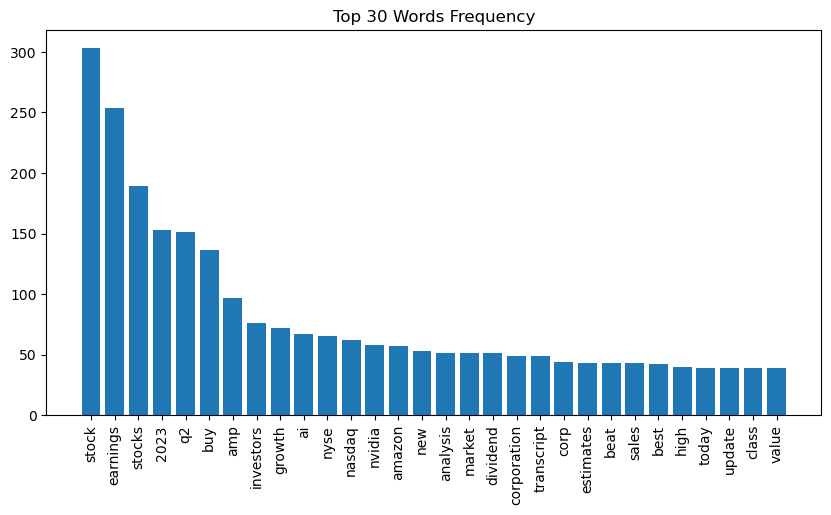

In [47]:
# Vectorize the text data to count word occurrences
vectorizer = CountVectorizer(stop_words='english')
X_counts = vectorizer.fit_transform(data_cleaned['title'])

# Sum up the counts of each word in the vocabulary
word_counts = X_counts.toarray().sum(axis=0)
word_freq = [(word, word_counts[idx]) for word, idx in vectorizer.vocabulary_.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)

# Plot the top 30 most frequent words
words = [wf[0] for wf in word_freq[:30]]
counts = [wf[1] for wf in word_freq[:30]]
plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xticks(rotation=90)
plt.title("Top 30 Words Frequency")
plt.show()

These words make sens for the data set and it's interesting to look at them. 

Now lets look at the distribution of lengths of all the different headlines

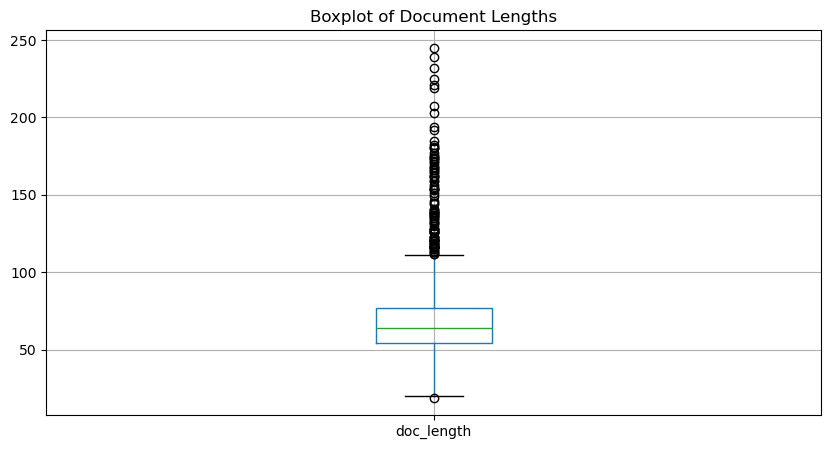

In [48]:
# Calculate the length of each document
data_cleaned['doc_length'] = data_cleaned['title'].apply(len)

# Plot a boxplot of document lengths
plt.figure(figsize=(10, 5))
data_cleaned.boxplot(column='doc_length')
plt.title("Boxplot of Document Lengths")
plt.show()

The boxplot is interesting and we can see several document lengths above the box area of the plot.

I think to better understand the distribution, we need to look at a histogram.

<Axes: >

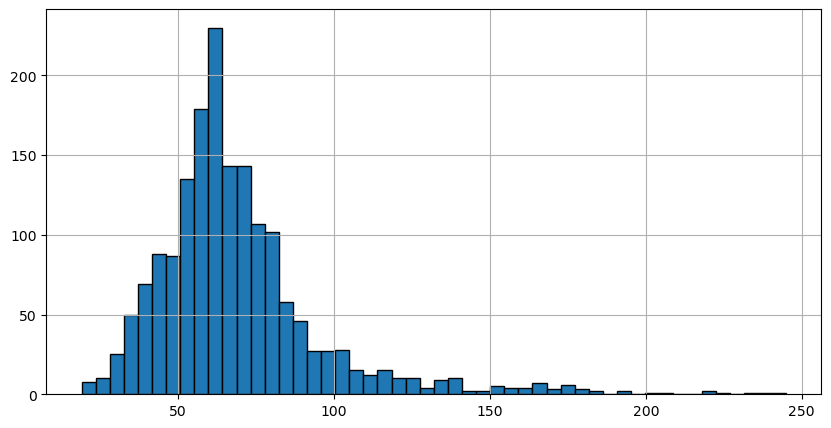

In [49]:
data_cleaned['doc_length'].hist(bins=50, edgecolor='black', figsize=(10, 5))

The histogram has a right tail but the majority of the data fits into a normal distribution, centered around ~60. 
I don't think we need to worry much about vastly different document lengths and we can move forward transforming the data into a form suitable for modeling.

We will start by removing "stopwords" using the nltk package. Stopwords are common words that don't add any meaning to the sentence such as "the", "of", "by", etc.

We will then use the SnowballStemmer from nltk to transform words into their "stem" form. This means transforming words like "running" or "ran" to their stem form of "run". And while we're at it, we will remove digits and non-word characters such as underscores, plus symbols, etc.

In [50]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sethr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [51]:
# Initialize stemmer and stopwords
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text) #removes non-word characters
    text = re.sub(r'\d+', '', text) #removes digits
    text = text.lower() #transforms all text to lowercase
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing to the text data
clean_text = data_cleaned['title'].apply(preprocess_text)

Now that we have cleaned text, we will tranform it into a sparse matrix of word counts that we can use for modeling.

This is accomplished using the TF-IDF (term frequency inverse document frequency) vectorizor from scikit-learn. This algorithm normalizes the word count of words by how frequenctly they appear in all documents (headlines in this case). For example, if the word "stock" appears in a headline but it also appears in many headlines, then its importance is lowered because it appears in many headlines. But a word like "earnings" may only appear in some headlines so its importance in documents where it does appear is increased.

In [52]:
# Transform the cleaned text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(clean_text)

<H2>Clustering Algorithms</H2>

Now that we have a data matrix we can model, we text different types of models to see which work best.

I know that I want two clusters - one for editorial articles and one for event-driven articles. I'm guessing about half the articles are editorial, although I don't know the exact number. 

So I'll be checking the size of the clusters in each algorithm and if two significant sized clusters are formed, I will look at a sample of the headlines in each cluster to determine of it performed well.

<H4>Kmeans</H4>

Kmeans clustering is an unsupervised machine learning algorithm that partitions data into a specified number of clusters (k) by iteratively assigning data points to one of k clusters based on the nearest centroid point, and then updating the centroid as the mean of the assigned points until convergence.

In [53]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_tfidf)

labels_kmeans = kmeans.labels_
data_cleaned['cluster_kmeans'] = labels_kmeans

In [54]:
data_cleaned['cluster_kmeans'].value_counts()

cluster_kmeans
0    1239
1     456
Name: count, dtype: int64

These are interesting cluster sizes - worth looking at the headlines in each cluster.

In [55]:
data_cleaned[data_cleaned['cluster_kmeans']==0]['title'].head()

0     American Airlines’ Pilots Ratify Contract With...
1     American Airlines pilots ratify a new contract...
4     SoftBank rises as chip unit Arm files for Nasd...
8     Down 10% in a Month, Does Apple Still Deserve ...
10    Analog Devices (ADI) to Post Q3 Earnings: What...
Name: title, dtype: object

In [56]:
data_cleaned[data_cleaned['cluster_kmeans']==1]['title'].head()

2     Buying These 3 Stocks Could Be the Smartest In...
6     Tap These Stocks &amp; ETFs to Play Like Billi...
17    Applied Materials (AMAT) Upgraded to Buy: What...
18    2 Under-the-Radar Gaming Stocks You Can Buy an...
26    Got $1,000? 3 Top Growth Stocks to Buy That Co...
Name: title, dtype: object

It appears that Kmeans may have done a pretty good job dividing the headlines. The cluster labels 0 has headlines that talk about ratifying contracts and posting earnings (event driven headlines). The cluster labeled with one has editorial sounding healines like "Buying These 3 Stocks Could Be the Smartest In..."

These results are very promising! I want to try different algorithms before I export the data and take a more thorough look at the headlines in each cluster.

<H4>DBSCAN</H4>

Unlike KMeans, DBSCAN doesn't necessarily need to put every data point into a cluster. Considering this, you could actually call KMeans a partitioning algorithms rather than a clustering algorithm.

DBSCAN requires two parameters to be set for your model: epsilon and minimum number of points. Epsilon represents your window size - how close two points must be to be considered part of a cluster. The minimum number of pointsrequires a certain number of points to be within that window for the algorithm to call something a cluster.

These two parameters can be difficult to optimize so I like to loop through several possibilities iteratively until I find parameters that output a model close to what I would expect.

In [57]:
# I'm going to create a function that loops through several epsilon and min_pts values and tells me how many clusters and noise points there are for each combination

def make_dbscans(X,epsilons,min_pts):
    # X is the data to model and the two other variables are lists of values to loop through
    # The following for loops loop through each combination of epsilon and MinPts and print the number of clusters and noise points
    for eps in epsilons:
        for min_pt in min_pts:
            db = DBSCAN(eps=eps, min_samples=min_pt).fit(X)
            labels = db.labels_
            
            # Number of clusters (excluding noise, which is labeled as -1)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            
            # Number of noise points
            n_noise = list(labels).count(-1)
            
            print(f"Epsilon: {eps}, MinPts: {min_pt} --> Number of clusters: {n_clusters}, Number of noise points: {n_noise}")


In [58]:
# Lists of epsilon and MinPts values
epsilons = [0.3, 0.4, 0.5, 0.6, 0.7]
min_pts = [3, 4, 5, 6, 7]

In [59]:
make_dbscans(X_tfidf, epsilons, min_pts)

Epsilon: 0.3, MinPts: 3 --> Number of clusters: 1, Number of noise points: 1692
Epsilon: 0.3, MinPts: 4 --> Number of clusters: 0, Number of noise points: 1695
Epsilon: 0.3, MinPts: 5 --> Number of clusters: 0, Number of noise points: 1695
Epsilon: 0.3, MinPts: 6 --> Number of clusters: 0, Number of noise points: 1695
Epsilon: 0.3, MinPts: 7 --> Number of clusters: 0, Number of noise points: 1695
Epsilon: 0.4, MinPts: 3 --> Number of clusters: 1, Number of noise points: 1692
Epsilon: 0.4, MinPts: 4 --> Number of clusters: 0, Number of noise points: 1695
Epsilon: 0.4, MinPts: 5 --> Number of clusters: 0, Number of noise points: 1695
Epsilon: 0.4, MinPts: 6 --> Number of clusters: 0, Number of noise points: 1695
Epsilon: 0.4, MinPts: 7 --> Number of clusters: 0, Number of noise points: 1695
Epsilon: 0.5, MinPts: 3 --> Number of clusters: 1, Number of noise points: 1692
Epsilon: 0.5, MinPts: 4 --> Number of clusters: 0, Number of noise points: 1695
Epsilon: 0.5, MinPts: 5 --> Number of cl

The previous epsilons may have been too small, let's try bigger ones

In [60]:
epsilons = [1, 2, 5, 10]
min_pts = [3, 4, 5, 6, 7]
make_dbscans(X_tfidf, epsilons, min_pts)

Epsilon: 1, MinPts: 3 --> Number of clusters: 68, Number of noise points: 1341
Epsilon: 1, MinPts: 4 --> Number of clusters: 30, Number of noise points: 1480
Epsilon: 1, MinPts: 5 --> Number of clusters: 16, Number of noise points: 1550
Epsilon: 1, MinPts: 6 --> Number of clusters: 8, Number of noise points: 1600
Epsilon: 1, MinPts: 7 --> Number of clusters: 6, Number of noise points: 1622
Epsilon: 2, MinPts: 3 --> Number of clusters: 1, Number of noise points: 0
Epsilon: 2, MinPts: 4 --> Number of clusters: 1, Number of noise points: 0
Epsilon: 2, MinPts: 5 --> Number of clusters: 1, Number of noise points: 0
Epsilon: 2, MinPts: 6 --> Number of clusters: 1, Number of noise points: 0
Epsilon: 2, MinPts: 7 --> Number of clusters: 1, Number of noise points: 0
Epsilon: 5, MinPts: 3 --> Number of clusters: 1, Number of noise points: 0
Epsilon: 5, MinPts: 4 --> Number of clusters: 1, Number of noise points: 0
Epsilon: 5, MinPts: 5 --> Number of clusters: 1, Number of noise points: 0
Epsilon

We get descent results with epsilon equal to 1 but maybe we can fine-tune it a little more

In [61]:
epsilons = [1.1, 1.2, 1.3, 1.5]
min_pts = [3, 4, 5, 6, 7]
make_dbscans(X_tfidf, epsilons, min_pts)

Epsilon: 1.1, MinPts: 3 --> Number of clusters: 45, Number of noise points: 971
Epsilon: 1.1, MinPts: 4 --> Number of clusters: 25, Number of noise points: 1087
Epsilon: 1.1, MinPts: 5 --> Number of clusters: 21, Number of noise points: 1157
Epsilon: 1.1, MinPts: 6 --> Number of clusters: 17, Number of noise points: 1232
Epsilon: 1.1, MinPts: 7 --> Number of clusters: 12, Number of noise points: 1307
Epsilon: 1.2, MinPts: 3 --> Number of clusters: 28, Number of noise points: 446
Epsilon: 1.2, MinPts: 4 --> Number of clusters: 17, Number of noise points: 529
Epsilon: 1.2, MinPts: 5 --> Number of clusters: 12, Number of noise points: 602
Epsilon: 1.2, MinPts: 6 --> Number of clusters: 7, Number of noise points: 652
Epsilon: 1.2, MinPts: 7 --> Number of clusters: 5, Number of noise points: 714
Epsilon: 1.3, MinPts: 3 --> Number of clusters: 1, Number of noise points: 26
Epsilon: 1.3, MinPts: 4 --> Number of clusters: 1, Number of noise points: 30
Epsilon: 1.3, MinPts: 5 --> Number of clus

An epsilong of 1.3 and MinPts of 7 gives us two clusters with a small number of noise points.

So I need to retrain the model using these parameters and check to make sure I get the same results. Then I can use that model as my final DBSCAN model for performance evaluation.


In [62]:
db = DBSCAN(eps=1.3, min_samples=7).fit(X_tfidf)
labels_db = db.labels_
n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise = list(labels_db).count(-1)

print(f'Clusters = {n_clusters}, Noise Points = {n_noise}')


Clusters = 2, Noise Points = 35


We got the model we were hoping for. Now let's look at the sizes of the clusters.


In [63]:
data_cleaned["DBSCAN_Clusters"] = labels_db


In [64]:
data_cleaned['DBSCAN_Clusters'].value_counts()

DBSCAN_Clusters
 0    1657
-1      35
 1       3
Name: count, dtype: int64

We see that one cluster contains the vast majority of data points using DBSCAN. Even by optimizing the epsilon and minimum points per cluster, we can get good separation between data points. We must conclude that DBSCAN is not the right algorithm for this problem.

<H4>Agglomerative Heirarchical Clustering</H4>

Agglomerative hierarchical clustering is a “bottom up approach” in that it beings with each data point being separate. It then clusters the closest points to form a new point as either the average of the two points or another metric that can be specified. The process continues until all points are clustered. If you specify a number of clusters you want, the algorithm is the same and runs to completion but the model outputs the results before it makes the final clusterings. In this way, you get a hierarchy of points that are closer together by whichever distance metric you specify. Another parameter that requires specification is the linkage, which governs how distance is calculate from an already formed cluster to another point or another cluster.

For this project, I explored two types of distances/linkage combinations:
1. Euclidean with ward linkage
2. Cosine distance with average distance

<H5>Agglomerative Heirarchical Clustering using Euclidean Distance and Ward Linkage</H5>

In [65]:
ag_avg = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward', compute_distances=True)
# X_tfidf is a sparse matrix from the scipy library and the algorithm wants an array so we must convert it
ag_avg.fit(X_tfidf.toarray())

# Get the cluster assignments
labels_ag_euc = ag_avg.labels_
data_cleaned['cluster_ag_euc'] = labels_ag_euc

In [66]:
data_cleaned['cluster_ag_euc'].value_counts()

cluster_ag_euc
0    1636
1      59
Name: count, dtype: int64

Perhaps euclidean distance isn't appropriate for this problem. Let's try a similarity algorithm like cosine.

We must change the linkage to average because ward only works with euclidean distance.

In [67]:
ag_cos = AgglomerativeClustering(n_clusters=2, metric='cosine', linkage='average')
ag_cos.fit(X_tfidf.toarray())

# Get the cluster assignments
labels_ag_cos = ag_cos.labels_
data_cleaned['cluster_ag_cos'] = labels_ag_cos

In [68]:
data_cleaned['cluster_ag_cos'].value_counts()

cluster_ag_cos
0    1694
1       1
Name: count, dtype: int64

<H3>Visualizing and Analyzing the Results</H3>



The main way to analyze the results, because the data was not labeled and this is unsupervised learning, is manually - put the data in CSV to read the full headlines and see if the cluster assignments make sense.

I will manually inspect 20 headlines from each cluster (for the clustering results that have at least 20 headlines to inspect) and judge if it did a good job separating editorial from event-driven headlines.

In [69]:

columns_to_save = ['title', 'cluster_kmeans', 'DBSCAN_Clusters','cluster_ag_euc', 'cluster_ag_cos']
data_cleaned[columns_to_save].to_csv('Stock Headlines Title and Cluster Assignments to Inspect.csv')

Upon manual inspection of the headlines clustered by KMeans and hierarchical clustering with euclidean distance (the only methods that produced two clusters large enough to inspect), one group from each method was nearly all editorial articles which is good. The other group, however, contained a mix of event-driven articles and editorial articles. So these models would have a high false negative rate for detecting editorial articles. This may be unideal when trying to identify buying opportunities for stocks with recent news. 

The Kmeans model identified more editorial articles than hierarchical clustering. Even though it did not identify all of them, it may act as a good first filter to remove several editorial articles before another model is applied to the remaining articles. KMeans is considered fast and computational efficient at making new predictions after a model has been trained, making it an ideal model for the fast paced world of stock trading.

<H5>Visualizing the Results with PCA</H5>

Although the manual inspection was the main form of evaluation, visualizations may provide insights into the models and how to improve them.

I will use principal component analysis (PCA) to visualize the results, coloring the different clusters different colors.

In addition, I will also make a dendrogram of the heirarchical clustering

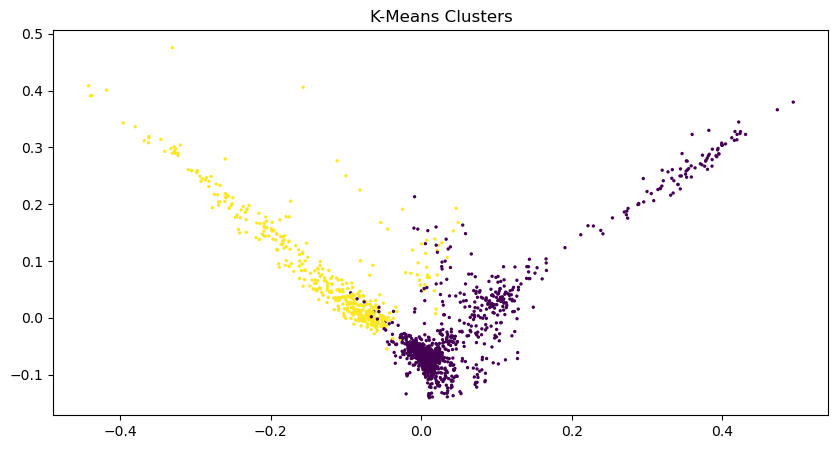

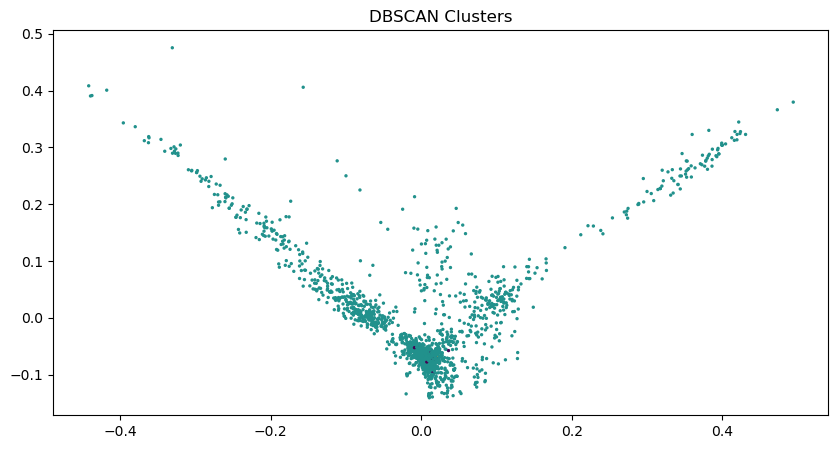

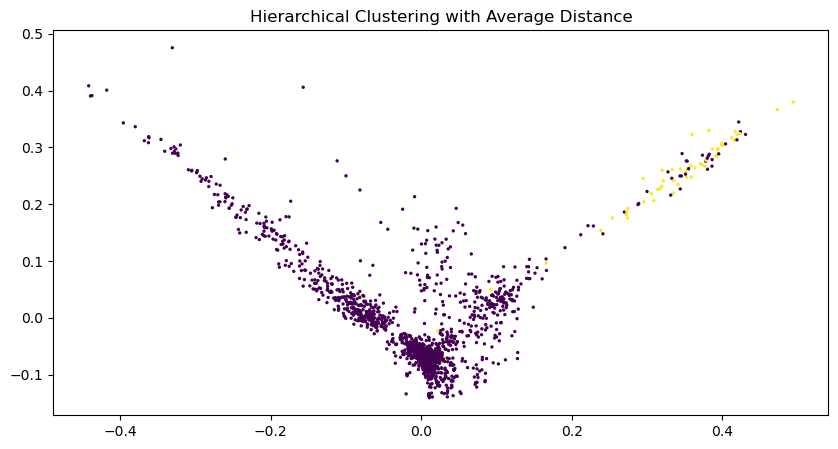

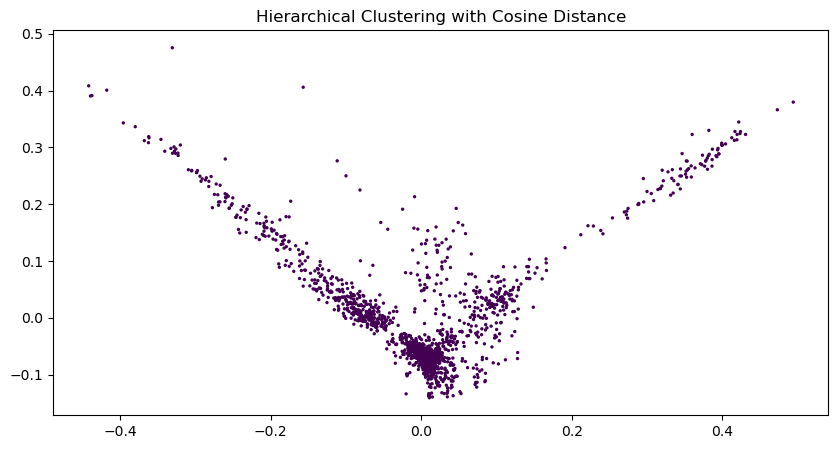

In [70]:
# Because we're making multiple plots, it will be easier to put the plotting code in a function
def plot_clusters(X_pca, labels, title):
    plt.figure(figsize=(10, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=2)
    plt.title(title)
    plt.show()

# Reduce dimensions to 2 for visualization
X_pca = PCA(n_components=2).fit_transform(X_tfidf.toarray())

# Visualize clusters
plot_clusters(X_pca, labels_kmeans, 'K-Means Clusters')
plot_clusters(X_pca, labels_db, 'DBSCAN Clusters')
plot_clusters(X_pca, labels_ag_avg, 'Hierarchical Clustering with Average Distance')
plot_clusters(X_pca, labels_ag_cos, 'Hierarchical Clustering with Cosine Distance')

The smaller cluster of the DBSCAN is difficult to see even though it contains enough points to be visible. I will make sure to plot the smaller cluster on top of the first and it will have large red dots.

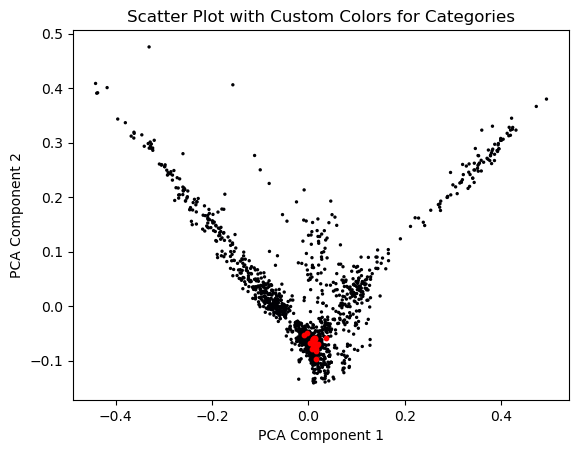

In [71]:
# Plot points labeled 0 and 1 first
mask_0_and_1 = (labels_db == 0) | (labels_db == 1)
plt.scatter(X_pca[mask_0_and_1, 0], X_pca[mask_0_and_1, 1], c=labels_db[mask_0_and_1], cmap='inferno', s=2)

# Plot points labeled -1 on top
mask_minus_1 = (labels_db == -1)
plt.scatter(X_pca[mask_minus_1, 0], X_pca[mask_minus_1, 1], c='red', s=10)  # Use a larger size to ensure visibility

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Scatter Plot with Custom Colors for Categories')
plt.show()

I'm curioius where the noise points for the DBSCAN algorithm are so I'm going to plot them in the same way I just did for the second cluster - with large red dots.


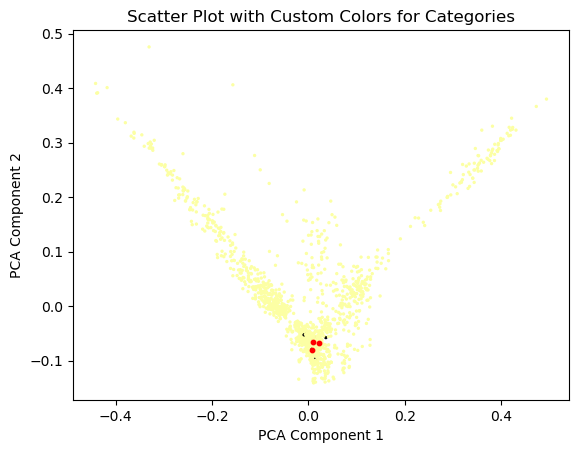

In [72]:
# Plot points labeled 0 and 1 first
mask_0_and_m1 = (labels_db == 0) | (labels_db == -1)
plt.scatter(X_pca[mask_0_and_m1, 0], X_pca[mask_0_and_m1, 1], c=labels_db[mask_0_and_m1], cmap='inferno', s=2)

# Plot points labeled -1 on top
mask_1 = (labels_db == 1)
plt.scatter(X_pca[mask_1, 0], X_pca[mask_1, 1], c='red', s=10)  # Use a larger size to ensure visibility

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Scatter Plot with Custom Colors for Categories')
plt.show()

It’s very interesting that the smaller cluster and the noise points exist in an area of high density on the PCA yet the points in low density are close enough to fit within the clustering window for the large cluster. This may indicate that the PCA does not capture a lot of the variability in the actual data and the dense area on the PCA is actually more spread out than it appears.

<H5>Dendrograms of the Hierarchicl Clustering</H5>

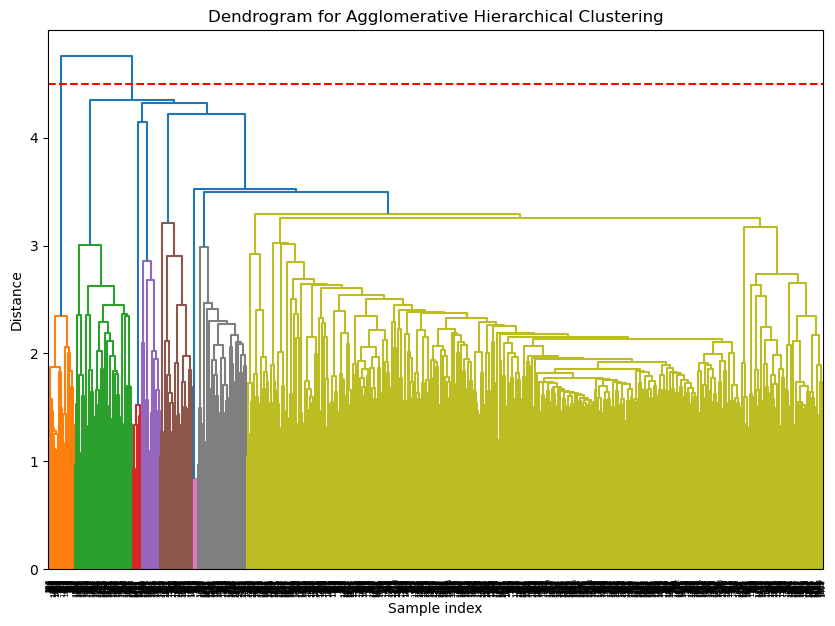

In [73]:
# We must get the "linage" of each point to others and from each cluster to other clusters as you go up the hierarchy
Z = linkage(X_tfidf.toarray(), method='ward', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title('Dendrogram for Agglomerative Hierarchical Clustering')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=4.5, color='r', linestyle='--') 

plt.show()

<H2>Key Findings</H2>

- Kmeans clustering performed best at separating editorial headlines from actual event-driven headlines. Clearly, this model suits the main objectives of this project best.

- DBSCAN clearly was not the right tool for the problem. It became clear that we are looking for a partitioning algorithm rather than pure clustering algorithm.

- Hierarchical clustering using average distance and ward linkage performed better than using cosine distance but still not as good as Kmeans. This was a little surprising as cosine distance is often used with text data.

- Upon manual inspection of the headlines clustered by Kmeans, one group was nearly all editorial articles which is good. The other group, however, contained a mix of event driven articles and editorial articles. So this model would have a high false negative rate for detecting editorial articles. This may be unideal when trying to identify buying opportunities for stocks with recent news.

<H2>Possible Flaws and Future Follow Up</H2>

A potential flaw in this study is that the classification is assumed to be binary. That is,it assumes all news articles are classified into either editorial or event-driven. But it’s possible some are in a gray area in between. For example, there are headlines such as “Q3 Earnings of Company XYZ to be Reported: Here’s What to Expect” which covers an upcoming event (an earnings report)
but also adds an opinion. Another flaw is that only headlines were used. We may have gotten better results if the entire content was considered. Finally, the TD-IDF algorithm is fairly simply in that only word counts are consider. An algorithm that better understands the context of words or the meanings of sentences may have achieved better results.

Unsupervised methods were used for this problem simply because the data was not labeled as being editorial or event-driven. Follow up studies could attempt to label the data by hiring someone to go through several hundred articles and decide which are editorial and which are event-driven. That would turn this into a supervised learning problem. A follow up project could also attempt to use a more sophisticated algorithm that understands the context of words in sentences such as a recurrent neural network.